# Number of guests prediction demo

Stripped-down version of [this notebook](https://www.kaggle.com/code/atasaygin/hotel-booking-demand-eda-and-of-guest-prediction).

**Performance** 
- Hotel booking demand dataset
    - Test MAPE City Hotel: 0.249210
    - Test MAPE Resort Hotel: 0.241623
- Lumen dataset `data/raw/lumen_dataset`

# Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_absolute_percentage_error
import os

for dirname, _, filenames in os.walk('..\\data\\raw'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
warnings.filterwarnings("ignore")

..\data\raw\export_df.parquet


In [2]:
data = pd.read_parquet('../data/raw/export_df.parquet')
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119210 entries, 0 to 119209
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   hotel_id                       119210 non-null  int32         
 1   datum_dolaska                  119210 non-null  datetime64[ns]
 2   datum_kreiranja_rezervacije    119210 non-null  datetime64[ns]
 3   datum_odjave                   119210 non-null  datetime64[ns]
 4   datum_otkazivanja_rezervacije  44199 non-null   object        
 5   broj_odraslih_gostiju          119210 non-null  int64         
 6   broj_djece_gostiju             119210 non-null  float64       
 7   zemlja_gosta                   119210 non-null  object        
 8   kanal_prodaje_id               119210 non-null  int32         
 9   tip_sobe_id                    119210 non-null  int32         
 10  cijena_nocenja                 119210 non-null  float64       
 11  

In [4]:
NaN = data.isna().sum()
NaN

hotel_id                             0
datum_dolaska                        0
datum_kreiranja_rezervacije          0
datum_odjave                         0
datum_otkazivanja_rezervacije    75011
broj_odraslih_gostiju                0
broj_djece_gostiju                   0
zemlja_gosta                         0
kanal_prodaje_id                     0
tip_sobe_id                          0
cijena_nocenja                       0
status_rezervacije                   0
rezervacija_id                       0
gost_id                              0
dtype: int64

# Čišćenje podataka 

In [5]:
data = data.dropna(subset=['zemlja_gosta', 'broj_djece_gostiju','datum_dolaska'], axis=0)
data = data.reset_index(drop=True)
data.head()

orig_len = len(data)

In [6]:
print(f"Resort (hotel id 0) ima {len(data[data['hotel_id']==0])} zapisa")
print(f"City (hotel id 1) ima {len(data[data['hotel_id']==1])} zapisa")


Resort (hotel id 0) ima 40047 zapisa
City (hotel id 1) ima 79163 zapisa


#### Uklanjanje zapisa (redaka) gdje je zemlja gosta 0 

In [7]:
print(f"Govorimo o {len(data[data['zemlja_gosta']=='0'])} redaka, odnosno {len(data[data['zemlja_gosta']=='0'])/len(data)*100}% podataka")
data = data[~(data['zemlja_gosta']=='0')]
print(f"Resort ima {len(data[data['hotel_id']==0])} zapisa")
print(f"City ima {len(data[data['hotel_id']==1])} zapisa")


Govorimo o 552 redaka, odnosno 0.4630484019796997% podataka
Resort ima 39583 zapisa
City ima 79075 zapisa


In [8]:
data['broj_djece_gostiju'] = data['broj_djece_gostiju'].astype(int)
data['broj_djece_gostiju'].dtype 

dtype('int32')

In [9]:
NaN_updated = data.isna().sum()
NaN_updated

hotel_id                             0
datum_dolaska                        0
datum_kreiranja_rezervacije          0
datum_odjave                         0
datum_otkazivanja_rezervacije    74553
broj_odraslih_gostiju                0
broj_djece_gostiju                   0
zemlja_gosta                         0
kanal_prodaje_id                     0
tip_sobe_id                          0
cijena_nocenja                       0
status_rezervacije                   0
rezervacija_id                       0
gost_id                              0
dtype: int64

In [10]:
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0,GBR,2,1,130.973278,Check-Out,1313227,1093703


# Stvaranje novih značajki (feature engineering)

##### Računanje ukupnog broja gostiju za svaki redak (djeca + odrasli)

In [11]:
data['ukupno_gostiju'] = data['broj_odraslih_gostiju'] + data['broj_djece_gostiju']
data['ukupno_gostiju'].head(10)

0    2
1    2
2    1
3    1
4    2
5    2
6    2
7    2
8    2
9    2
Name: ukupno_gostiju, dtype: int64

#### Duljina boravka - datum odlaska - datum dolaska

In [12]:
data['duljina_boravka'] = data['datum_odjave'] - data['datum_dolaska']
data['duljina_boravka'] = data['duljina_boravka'].dt.days
data.head(10)


,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id,ukupno_gostiju,duljina_boravka
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0,PRT,0,0,100.000000,Check-Out,1313223,1077152,2,0
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0,PRT,0,0,100.000000,Check-Out,1313224,1017906,2,0
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0,GBR,0,1,64.991345,Check-Out,1313225,1039896,1,1
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0,GBR,1,1,74.368897,Check-Out,1313226,1008245,1,1
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0,GBR,2,1,130.973278,Check-Out,1313227,1093703,2,2
5,0,2015-07-01,2015-04-21,2015-07-03,None,2,0,GBR,2,1,143.304560,Check-Out,1313228,1044263,2,2
6,0,2015-07-01,2015-06-25,2015-07-03,None,2,0,PRT,0,0,161.502814,Check-Out,1313229,1022260,2,2
7,0,2015-07-01,2014-09-15,2015-07-03,None,2,0,PRT,0,0,151.176542,Check-Out,1313230,1101557,2,2
8,0,2015-07-01,2015-06-30,2015-07-04,2015-05-06,2,0,PRT,2,1,61.437192,Canceled,1313231,1075633,2,3
9,0,2015-07-01,2015-06-28,2015-07-04,2015-04-22,2,0,PRT,2,2,150.365262,Canceled,1313232,1056139,2,3


##### Uklanjanje rezervacija u kojima nema gostiju, odnosno ukupan je broj gostiju 0

In [13]:
data = data[data['ukupno_gostiju'] != 0]

##### Filtriranje podataka na temelju stupca datum_otkazivanja_rezervacije
- Ukoliko je datum otkazivanja rezervacije vrijednost (datum) znači da je rezervacija otkazan i to na taj dan

In [14]:
data = data[~data['datum_otkazivanja_rezervacije'].notna()]
data = data.reset_index(drop=True)

In [15]:
print(f"Imamo {len(data)} zapisa za stvarne dolaske, odnosno {len(data)/orig_len*100}% podataka")

Imamo 74553 zapisa za stvarne dolaske, odnosno 62.53921650868216% podataka


In [16]:
dataResort = data[data['hotel_id'] == 0]
dataCity = data[data['hotel_id'] == 1]

assert len(dataResort) + len(dataCity) == len(data)

In [17]:
print(f"Resort ima {len(dataResort)} zapisa")
print(f"City ima {len(dataCity)} zapisa")

Resort ima 28506 zapisa
City ima 46047 zapisa


### Dodavanje ciljane varijable - ukupan broj gostiju u nekom periodu, na dnevnoj, tjednoj, mjesečnoj i godišnjoj razini

### City Hotel

In [18]:
NumberOfGuestsCity = dataCity[['datum_dolaska', 'ukupno_gostiju']]
NumberOfGuestsCity.head(5)

,datum_dolaska,ukupno_gostiju
28506,2015-11-01,1
28507,2015-07-02,1
28508,2015-10-03,2
28509,2015-07-03,2
28510,2015-12-03,2


#### Dnevna razina

In [19]:
NumberOfGuestsDailyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
org_len = NumberOfGuestsDailyCity = NumberOfGuestsDailyCity.resample('d').sum().to_frame()
NumberOfGuestsDailyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-01-01,10
2015-01-02,6
2015-01-03,11
2015-01-04,8
2015-01-05,4


#### OPCIONALNO

- ARIMA model, kao i MAPE metrika, ne reagiraju dobro na anomalije, odnosno MAPE puca (zbog djeljenja s nulom) za svaki dan/tjedan/mjesec kada 
  su podaci nula, odnosno u ovom slučaju za svaki slučaj kada je broj ukuopnih gosti na bilo kojoj vremenskoj bazi jednak nuli
- stoga, kako MAPE ne bi bio veličine beskonačno, odlučio sam izbaciti sve dane kada je broj gostiju jednak nuli 
 (alternativa je umetanje umjetnog broja,nasumično ili inteligentnijim pristupom kako bi se prešlo preko ovog problema)
 
 - PRETPOSTAVKA je kako su dani, tjedni i mjeseci s nula gostiju anomalija, kako je u pitanju "nasumičan" vremenski period, odnosno nema dovoljno 
   argumenata kojima bismo pokazali kako je broj gostiju nula zbog nekog drugog razloga (npr. sezonskih promjena, praznika, vikenda, itd.)

In [20]:
org_len = len(NumberOfGuestsDailyCity)
NumberOfGuestsDailyCity = NumberOfGuestsDailyCity[NumberOfGuestsDailyCity['ukupno_gostiju'] > 0]
print(f"Ostalo je {len(NumberOfGuestsDailyCity)} zapisa, odnosno {len(NumberOfGuestsDailyCity)/org_len*100}% od originalnog broja podataka")


Ostalo je 940 zapisa, odnosno 85.76642335766424% od originalnog broja podataka


#### Tjedna razina

In [23]:
NumberOfGuestsWeeklyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsWeeklyCity = NumberOfGuestsWeeklyCity.resample('w').sum().to_frame()
NumberOfGuestsWeeklyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-01-04,35
2015-01-11,42
2015-01-18,54
2015-01-25,48
2015-02-01,27


#### OPCIONALNO

In [24]:
org_len = len(NumberOfGuestsWeeklyCity)
NumberOfGuestsWeeklyCity = NumberOfGuestsWeeklyCity[NumberOfGuestsWeeklyCity['ukupno_gostiju'] > 0]
print(f"Ostalo je {len(NumberOfGuestsWeeklyCity)} zapisa, odnosno {len(NumberOfGuestsWeeklyCity)/org_len*100}% od originalnog broja podataka")


Ostalo je 138 zapisa, odnosno 87.89808917197452% od originalnog broja podataka


#### Mjesečna razina

In [25]:
NumberOfGuestsMonthlyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsMonthlyCity = NumberOfGuestsMonthlyCity.resample('m').sum().to_frame()
NumberOfGuestsMonthlyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-01-31,206
2015-02-28,0
2015-03-31,0
2015-04-30,0
2015-05-31,1072


#### OPCIONALNO

In [27]:
org_len = len(NumberOfGuestsMonthlyCity)
NumberOfGuestsMonthlyCity  = NumberOfGuestsMonthlyCity[NumberOfGuestsMonthlyCity['ukupno_gostiju'] > 0]
print(f"Ostalo je {len(NumberOfGuestsMonthlyCity)} zapisa, odnosno {len(NumberOfGuestsMonthlyCity)/org_len*100}% od originalnog broja podataka")


Ostalo je 31 zapisa, odnosno 86.11111111111111% od originalnog broja podataka


#### Godišnja razina

In [28]:
NumberOfGuestsYearlyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsYearlyCity = NumberOfGuestsYearlyCity.resample('y').sum().to_frame()
NumberOfGuestsYearlyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-12-31,13723
2016-12-31,44405
2017-12-31,31254


### Resort Hotel

In [29]:
NumberOfGuestsResort = dataResort[['datum_dolaska', 'ukupno_gostiju']]
NumberOfGuestsResort.head(5)

,datum_dolaska,ukupno_gostiju
0,2015-07-01,2
1,2015-07-01,2
2,2015-07-01,1
3,2015-07-01,1
4,2015-07-01,2


#### Dnevna razina

In [30]:
NumberOfGuestsDailyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsDailyResort = NumberOfGuestsDailyResort.resample('d').sum().to_frame()
NumberOfGuestsDailyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-07-01,67
2015-07-02,72
2015-07-03,59
2015-07-04,80
2015-07-05,80


#### Tjedna razina

In [31]:
NumberOfGuestsWeeklyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsWeeklyResort = NumberOfGuestsWeeklyResort.resample('w').sum().to_frame()
NumberOfGuestsWeeklyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-07-05,358
2015-07-12,495
2015-07-19,537
2015-07-26,533
2015-08-02,554


#### Mjesečna razina

In [32]:
NumberOfGuestsMonthlyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsMonthlyResort = NumberOfGuestsMonthlyResort.resample('m').sum().to_frame()
NumberOfGuestsMonthlyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-07-31,2300
2015-08-31,2318
2015-09-30,2013
2015-10-31,2108
2015-11-30,1534


#### Godišnja razina

In [33]:
NumberOfGuestsYearlyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsYearlyResort = NumberOfGuestsYearlyResort.resample('y').sum().to_frame()
NumberOfGuestsYearlyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-12-31,12053
2016-12-31,26091
2017-12-31,17816


# ARIMA model za predviđanje budućeg broja gostiju - City Hotel

## Predviđanje dnevnog broja gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju gostiju

##### Augmented Dickey-Fuller (ADF) test se koristi u statistici i ekonometriji za testiranje prisutnosti tzv. "jediničnog korijena" (unit root) u vremenskim serijama
##### Jedinični korijen ukazuje na to da vremenska serija nije stacionarna, što znači da njene statističke karakteristike kao što su srednja vrijednost, varijanca i autokorelacija, se mijenjaju tijekom vremena
##### Nulta hipoteza (H0): Postoji jedinični korijen, tj. serija je nestacionarna.
##### Alternativna hipoteza (H1): Ne postoji jedinični korijen, tj. serija je stacionarna.

In [34]:
CityDailyValues = NumberOfGuestsDailyCity.values
result_city_daily = adfuller(CityDailyValues)
print('ADF Statistic: %f' % result_city_daily[0])
print('p-value: %f' % result_city_daily[1])
print('Critical Values:')
for key, value in result_city_daily[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.868268
p-value: 0.049164
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela

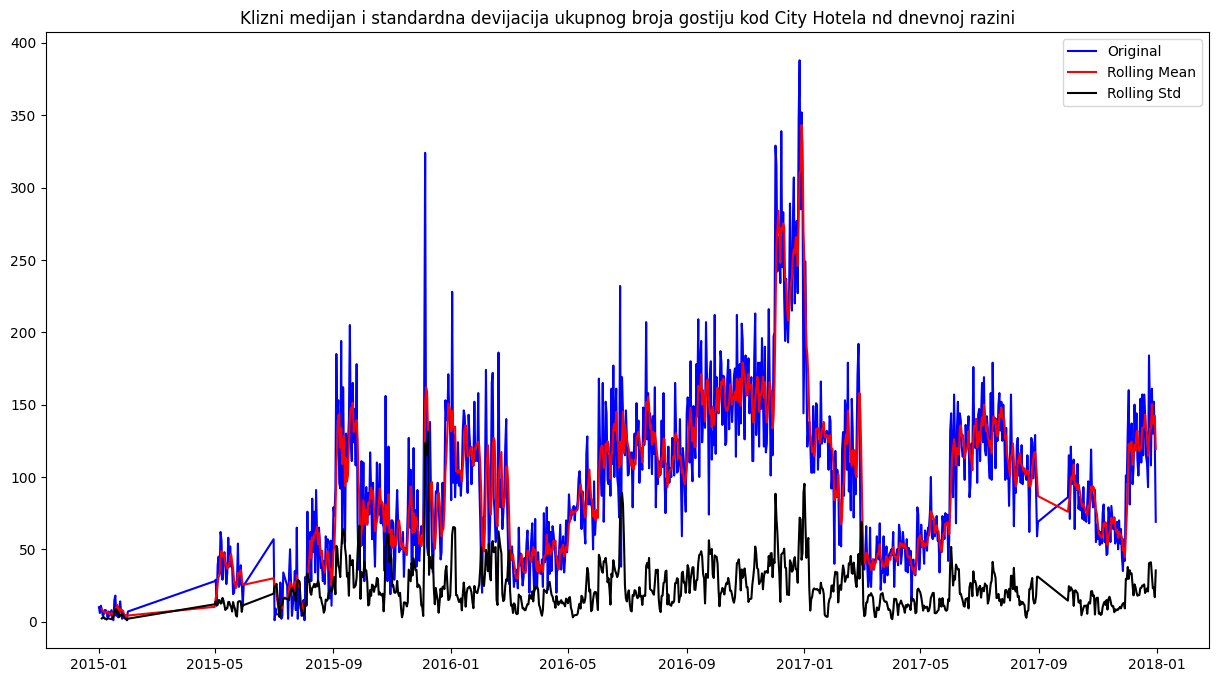

In [35]:
plt.figure(figsize=(15, 8))
rolling_mean_city_daily = NumberOfGuestsDailyCity.rolling(window=4).mean()
rolling_std_city_daily = NumberOfGuestsDailyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsDailyCity, color='blue', label='Original')
plt.plot(rolling_mean_city_daily, color='red', label='Rolling Mean')
plt.plot(rolling_std_city_daily, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod City Hotela nd dnevnoj razini')
plt.show()

#### Train / test split podataka

In [36]:
split_ratio  =  0.8

In [37]:
train_test_split_city_daily = int(len(NumberOfGuestsDailyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_daily} podataka, test {len(NumberOfGuestsDailyCity)-train_test_split_city_daily} podataka")

trainCityDaily = NumberOfGuestsDailyCity[:train_test_split_city_daily]
testCityDaily = NumberOfGuestsDailyCity[train_test_split_city_daily:]

Split 0.8 na train/test, train ima 752 podataka, test 188 podataka


#### Fit ARIMA modela na podatke na dnevnoj bazi

- Iz službene dokumentacije (https://alkaline-ml.com/pmdarima/tips_and_tricks.html#period):
   - The m parameter relates to the number of observations per seasonal cycle, and is one that must be known apriori. Typically, m will correspond to some recurrent periodicity such as:
    - 7 - daily
    - 12 - monthly
    - 52 - weekly

- parametar 'd' koristi se ako je potrebno diferencirati vremensku seriju, odnosno postavljamo ga na None ako ne znamo kako diferencirati podatke,
a inače na int vrijednost (tipično 1). Zaklkučak o tome izvodimo iz Augmented Dickey-Fuller Test koji testira jesu li neki podaci u vremenskoj seriji 
stacionarni ili nisu

- Vremenska je serija stacionarna kada su joj  medijan, varijanca, auto-korelacija i slične metrike konstante kroz vrijeme t.
ARIMA pretpostavlja da podaci postaju stacionarni nako diferenciranja, ukoliko je d postavljen an vrijednost veću od nule, što
se naziva diferencijablna stacionarnost. auto_arima određuje i optimalni d.

In [38]:
stepwise_fit_city_daily = auto_arima(trainCityDaily['ukupno_gostiju'],
                          start_p=1, start_q=1,
                          max_p=5, max_q=5, m=7,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_city_daily.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=7818.719, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=7592.582, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=7561.272, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=7816.800, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=7743.021, Time=0.20 sec


- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,5)(1,1,1)[7] je najbolji model te se to preslikava u parametre
- order = (0,0,5)
- seasonal_order = (1,1,1,7)

In [ ]:
modelCity_daily = ARIMA(trainCityDaily['ukupno_gostiju'],
                  order=(0, 0, 5),
                  seasonal_order=(1, 1, 1, 7))

resultCity_daily = modelCity_daily.fit()


##### Predikcije modela na test podacima na dnevnoj bazi

In [ ]:
predictionsCityTestDaily = resultCity_daily.predict(train_test_split_city_daily, train_test_split_city_daily + len(testCityDaily) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na dnevnoj razini na testnim podacima


In [ ]:
plt.figure(figsize=(15, 8))
testCityDaily['ukupno_gostiju'].plot(legend=True)
predictionsCityTestDaily.plot(legend=True)
plt.title('Predikcija broja gostiju City Hotela na dnevnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
plt.figure(figsize=(15, 8))
trainCityDaily['ukupno_gostiju'].plot(legend=True)
predictionsCityTestDaily.plot(legend=True)
plt.title('Predikcija broja gostiju kod City Hotela na dnevnoj bazi', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
MeanAbsPercentageErrCityDaily_test = mean_absolute_percentage_error(testCityDaily, predictionsCityTestDaily)
print('Test MAPE City Hotel na dnevnoj razini: %f' % MeanAbsPercentageErrCityDaily_test)

## Predviđanje tjednog broja gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju gostiju

In [ ]:
CityWeeklyValues = NumberOfGuestsWeeklyCity.values
result_city_weekly = adfuller(CityWeeklyValues)
print('ADF Statistic: %f' % result_city_weekly[0])
print('p-value: %f' % result_city_weekly[1])
print('Critical Values:')
for key, value in result_city_weekly[4].items():
    print('\t%s: %.3f' % (key, value))

- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela

In [ ]:
plt.figure(figsize=(15, 8))
rolling_mean_city_weekly = NumberOfGuestsWeeklyCity.rolling(window=4).mean()
rolling_std_city_weekly = NumberOfGuestsWeeklyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsWeeklyCity, color='blue', label='Original')
plt.plot(rolling_mean_city_weekly, color='red', label='Rolling Mean')
plt.plot(rolling_std_city_weekly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod City Hotela na tjednoj razini')
plt.show()

In [ ]:
split_ratio  =  0.8

In [ ]:
train_test_split_city_weekly = int(len(NumberOfGuestsWeeklyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_weekly} podataka, test {len(NumberOfGuestsWeeklyCity)-train_test_split_city_weekly} podataka")

trainCityWeekly = NumberOfGuestsWeeklyCity[:train_test_split_city_weekly]
testCityWeekly = NumberOfGuestsWeeklyCity[train_test_split_city_weekly:]

#### Fit ARIMA modela na podatke na tjednoj bazi

In [ ]:
stepwise_fit_city_weekly = auto_arima(trainCityWeekly['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=52,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_city_weekly.summary()

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,1,0)(0,1,0)[52]  je najbolji model te se to preslikava u parametre
- order = (0,1,0)
- seasonal_order = (0,1,0,52)

In [ ]:
modelCityWeekly = ARIMA(trainCityWeekly['ukupno_gostiju'],
                  order=(0, 1, 0),
                  seasonal_order=(0, 1, 0, 52))

resultCityWeekly = modelCityWeekly.fit()


##### Predikcije modela na test podacima na tjednoj bazi

In [ ]:
predictionsCityTestWeekly = resultCityWeekly.predict(train_test_split_city_weekly, train_test_split_city_weekly + len(testCityWeekly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na tjednoj razini na testnim podacima


In [ ]:
plt.figure(figsize=(15, 8))
testCityWeekly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestWeekly.plot(legend=True)
plt.title('Predikcija Broja Gostiju City Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

### Predikcija broja gostiju na tjednoj razini

In [ ]:
plt.figure(figsize=(15, 8))
trainCityWeekly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestWeekly.plot(legend=True)
plt.title('Predikcija broja gostiju kod City Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
MeanAbsPercentageErrCityWeekly_test = mean_absolute_percentage_error(testCityWeekly, predictionsCityTestWeekly)
print('Test MAPE City Hotel tjedna razina: %f' % MeanAbsPercentageErrCityWeekly_test)

## Predviđanje mjesečnog broja gostiju 


#### Dickey-Fuller test za podatke o mjesečnombroju gostiju

In [ ]:
CityMonthlyValues = NumberOfGuestsMonthlyCity.values
result_city_monthly = adfuller(CityMonthlyValues)
print('ADF Statistic: %f' % result_city_monthly [0])
print('p-value: %f' % result_city_monthly [1])
print('Critical Values:')
for key, value in result_city_monthly [4].items():
    print('\t%s: %.3f' % (key, value))

- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela Mjesečna razina

In [ ]:
plt.figure(figsize=(15, 8))
rolling_mean_city_monthly  = NumberOfGuestsMonthlyCity.rolling(window=4).mean()
rolling_std_city_monthly = NumberOfGuestsMonthlyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsMonthlyCity, color='blue', label='Original')
plt.plot(rolling_mean_city_monthly, color='red', label='Rolling Mean')
plt.plot(rolling_std_city_monthly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod City Hotela na mjesečnoj razini')
plt.show()

In [ ]:
split_ratio  =  0.8

In [ ]:
train_test_split_city_monthly = int(len(NumberOfGuestsMonthlyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_monthly} podataka, test {len(NumberOfGuestsMonthlyCity)-train_test_split_city_monthly} podataka")

trainCityMonthly = NumberOfGuestsMonthlyCity[:train_test_split_city_monthly]
testCityMonthly = NumberOfGuestsMonthlyCity[train_test_split_city_monthly:]

#### Fit ARIMA modela na podatke na mjesečnoj bazi

In [ ]:
stepwise_fit_city_monthly = auto_arima(trainCityMonthly['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_city_monthly.summary()

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(1,0,0)(0,1,0)[12] je najbolji model te se to preslikava u parametre
- order = (1,0,0)
- seasonal_order = (0,1,0,12)

In [ ]:
modelCityMonthly = ARIMA(trainCityMonthly['ukupno_gostiju'],
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 0, 12))

resultCityMonthly = modelCityMonthly.fit()


##### Predikcije modela na test podacima na mjesečnoj bazi

In [ ]:
predictionsCityTestMonthly = resultCityMonthly.predict(train_test_split_city_monthly, train_test_split_city_monthly + len(testCityMonthly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na mjesečnoj razini na testnim podacima


In [ ]:
plt.figure(figsize=(15, 8))
testCityMonthly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestMonthly.plot(legend=True)
plt.title('Predikcija broja gostiju City Hotela na mjesečnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

### Predikcija broja gostiju na mjesečnoj razini

In [ ]:
plt.figure(figsize=(15, 8))
trainCityMonthly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestMonthly.plot(legend=True)
plt.title('Predikcija broja gostiju kod City Hotela', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
MeanAbsPercentageErrCityMonthly_test = mean_absolute_percentage_error(testCityMonthly, predictionsCityTestMonthly)
print('Test MAPE City Hotel na mjesečnoj razini: %f' % MeanAbsPercentageErrCityMonthly_test)

# ARIMA model za predviđanje budućeg broja gostiju - Resort Hotel 


## Predviđanje dnevnog broja gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju gostiju

In [ ]:
ResortDailyValues = NumberOfGuestsDailyResort.values
result_resort_daily = adfuller(ResortDailyValues)
print('ADF Statistic: %f' % result_resort_daily[0])
print('p-value: %f' % result_resort_daily[1])
print('Critical Values:')
for key, value in result_resort_daily[4].items():
    print('\t%s: %.3f' % (key, value))

- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost manja od alfe,  možemo odbaciti H0, odnosno serija je stacionarna 

#### Rollling Mean i STD Resort Hotela na dnevnioj razini

In [ ]:
plt.figure(figsize=(15, 8))
rolling_mean_resort_daily = NumberOfGuestsDailyResort.rolling(window=4).mean()
rolling_std_resort_daily  = NumberOfGuestsDailyResort.rolling(window=4).std()
plt.plot(NumberOfGuestsDailyResort, color='blue', label='Original')
plt.plot(rolling_mean_resort_daily , color='red', label='Rolling Mean')
plt.plot(rolling_std_resort_daily , color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod Resort Hotela na dnevnoj razini')
plt.show()

In [ ]:
split_ratio  =  0.8

In [ ]:
train_test_split_resort_daily = int(len(NumberOfGuestsDailyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_daily} podataka, test {len(NumberOfGuestsDailyResort)-train_test_split_resort_daily} podataka")

trainResortDaily = NumberOfGuestsDailyResort[:train_test_split_resort_daily]
testResortDaily = NumberOfGuestsDailyResort[train_test_split_resort_daily:]

#### Fit ARIMA modela na podatke na dnevnoj bazi

In [ ]:
stepwise_fit_resort_daily = auto_arima(trainResortDaily['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=7,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_daily.summary()

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,1)(0,1,1)[7]    je najbolji model te se to preslikava u parametre
- order = (0, 0 ,1)
- seasonal_order = (0,1,1,7)


In [ ]:
modelResort_daily = ARIMA(trainResortDaily['ukupno_gostiju'],
                  order=(0, 0, 1),
                  seasonal_order=(0, 1, 1, 7))

resultResort_daily = modelResort_daily.fit()


##### Predikcije modela na test podacima na dnevnoj bazi

In [ ]:
predictionsResortTestDaily = resultResort_daily.predict(train_test_split_resort_daily, train_test_split_resort_daily + len(testResortDaily) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na dnevnoj razini na testnim podacima


In [ ]:
plt.figure(figsize=(15, 8))
testResortDaily['ukupno_gostiju'].plot(legend=True)
predictionsResortTestDaily.plot(legend=True)
plt.title('Predikcija broja gostiju Resort Hotela na dnevnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
plt.figure(figsize=(15, 8))
trainResortDaily['ukupno_gostiju'].plot(legend=True)
predictionsResortTestDaily.plot(legend=True)
plt.title('Predikcija dnevnog broja gostiju kod Resort Hotela', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
MeanAbsPercentageErrResortDaily_test = mean_absolute_percentage_error(testResortDaily, predictionsResortTestDaily)
print('Test MAPE Resort Hotel na dnevnoj razini: %f' % MeanAbsPercentageErrResortDaily_test)

## Predviđanje tjednog broja gostiju 


#### Dickey-Fuller test za podatke o tjednom broju gostiju

In [ ]:
ResortWeeklyValues = NumberOfGuestsWeeklyResort.values
result_resort_weekly = adfuller(ResortWeeklyValues)
print('ADF Statistic: %f' % result_resort_weekly [0])
print('p-value: %f' % result_resort_weekly [1])
print('Critical Values:')
for key, value in result_resort_weekly [4].items():
    print('\t%s: %.3f' % (key, value))

- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost manja od alfe,  možemo odbaciti H0, odnosno serija je stacionarna 

#### Rollling Mean i STD Resort Hotela na tjednoj razini

In [ ]:
plt.figure(figsize=(15, 8))
rolling_mean_resort_weekly = NumberOfGuestsWeeklyResort.rolling(window=4).mean()
rolling_std_resort_weekly = NumberOfGuestsWeeklyResort.rolling(window=4).std()
plt.plot(NumberOfGuestsWeeklyResort, color='blue', label='Original')
plt.plot(rolling_mean_resort_weekly, color='red', label='Rolling Mean')
plt.plot(rolling_std_resort_weekly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod Resort Hotela na tjednoj razini')
plt.show()

In [ ]:
split_ratio  =  0.8

In [ ]:
train_test_split_resort_weekly = int(len(NumberOfGuestsWeeklyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_weekly} podataka, test {len(NumberOfGuestsWeeklyResort)-train_test_split_resort_weekly} podataka")

trainResortWeekly = NumberOfGuestsWeeklyResort[:train_test_split_resort_weekly]
testResortWeekly = NumberOfGuestsWeeklyResort[train_test_split_resort_weekly:]

#### Fit ARIMA modela na podatke na tjednoj bazi

In [ ]:
stepwise_fit_resort_weekly = auto_arima(trainResortWeekly['ukupno_gostiju'], 
                          start_p=1, start_q=1,
                          max_p=3, max_q=3, m=54,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_weekly.summary()

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,0)(0,1,0)[54]    je najbolji model te se to preslikava u parametre
- order = (0,0,0)
- seasonal_order = (0,1,0)[54] 


In [ ]:
modelResort_weekly = ARIMA(trainResortWeekly['ukupno_gostiju'],
                  order=(0, 0, 0),
                  seasonal_order=(0, 1, 0, 54))

resultResort_weekly= modelResort_weekly.fit()


##### Predikcije modela na test podacima na tjednoj bazi

In [ ]:
predictionsResortTestWeekly = resultResort_weekly.predict(train_test_split_resort_weekly, train_test_split_resort_weekly + len(testResortWeekly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na tjednoj razini na testnim podacima


In [ ]:
plt.figure(figsize=(15, 8))
testResortWeekly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestWeekly.plot(legend=True)
plt.title('Predikcija broja gostiju Resort Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
plt.figure(figsize=(15, 8))
trainResortWeekly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestWeekly.plot(legend=True)
plt.title('Predikcija broja gostiju kod Resort Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
MeanAbsPercentageErrResortWeekly_test = mean_absolute_percentage_error(testResortWeekly, predictionsResortTestWeekly)
print('Test MAPE Resort Hotel na tjednoj razini: %f' % MeanAbsPercentageErrResortWeekly_test)

## Predviđanje mjesečnog broja gostiju 


#### Dickey-Fuller test za podatke o mjesečnom broju gostiju

In [ ]:
ResortMonthlyValues = NumberOfGuestsMonthlyResort.values
result_resort_monthly = adfuller(ResortMonthlyValues)
print('ADF Statistic: %f' % result_resort_monthly[0])
print('p-value: %f' % result_resort_monthly[1])
print('Critical Values:')
for key, value in result_resort_monthly[4].items():
    print('\t%s: %.3f' % (key, value))

- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, možemo odbaciti H0, odnosno serija je stacionarna 

#### Rollling Mean i STD Resort Hotela na mjesečnoj razini

In [ ]:
plt.figure(figsize=(15, 8))
rolling_mean_resort_monthly = NumberOfGuestsMonthlyResort.rolling(window=4).mean()
rolling_std_resort_monthly = NumberOfGuestsMonthlyResort.rolling(window=4).std()
plt.plot(NumberOfGuestsMonthlyResort, color='blue', label='Original')
plt.plot(rolling_mean_resort_monthly, color='red', label='Rolling Mean')
plt.plot(rolling_std_resort_monthly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod Resort Hotela na mjesečnoj razini')
plt.show()

In [ ]:
split_ratio  =  0.8

In [ ]:
train_test_split_resort_monthly = int(len(NumberOfGuestsMonthlyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_monthly} podataka, test {len(NumberOfGuestsMonthlyResort)-train_test_split_resort_monthly} podataka")

trainResortMonthly = NumberOfGuestsMonthlyResort[:train_test_split_resort_monthly]
testResortMonthly = NumberOfGuestsMonthlyResort[train_test_split_resort_monthly:]

In [ ]:
stepwise_fit_resort_monthly = auto_arima(trainResortMonthly['ukupno_gostiju'], 
                          start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_monthly.summary()

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,0)(0,1,0)[12]    je najbolji model te se to preslikava u parametre
- order = (0,0,0)
- seasonal_order = (0,1,0)[12] 


In [ ]:
modelResort_monthly = ARIMA(trainResortMonthly['ukupno_gostiju'],
                  order=(0, 0, 0),
                  seasonal_order=(0, 1, 0, 12))

resultResort_monthly= modelResort_monthly.fit()


##### Predikcije modela na test podacima na mjesečnoj bazi

In [ ]:
predictionsResortTestMonthly = resultResort_monthly.predict(train_test_split_resort_monthly, train_test_split_resort_monthly + len(testResortMonthly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na mjesečnoj razini na testnim podacima


In [ ]:
plt.figure(figsize=(15, 8))
testResortMonthly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestMonthly.plot(legend=True)
plt.title('Predikcija Broja Gostiju Resort Hotela na mjesečnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
plt.figure(figsize=(15, 8))
trainResortMonthly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestMonthly.plot(legend=True)
plt.title('Predikcija broja gostiju kod Resort Hotela na mjesečnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
MeanAbsPercentageErrResortMonthly_test = mean_absolute_percentage_error(testResortMonthly, predictionsResortTestMonthly)
print('Test MAPE Resort Hotel na mjesečnoj razini: %f' % MeanAbsPercentageErrResortMonthly_test)